In [16]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image, pyplot
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import hvplot.pandas

from PIL import Image
from skimage import io, color, exposure, transform, img_as_float32
import skimage

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import umap
import umap.plot

from itertools import product

from dask import bag, diagnostics
from scipy import stats

from pathlib import Path
import os, sys


sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
from importlib import reload
reload(leuko)



<module 'leukopy_lib' from '/Users/yahiabouzoubaa/Documents/GitHub/Leukopy/notebooks/leukopy_lib.py'>

In [17]:
# Import dataframe (id/path/label)
path_name = '../../data/PBC_dataset_normal_df.csv'
df = leuko.load_df(path_name)
df.head()

,img_paths,id,label,cell_type,height,width,mean_brightness,mean_luminance
0,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,225079,MO,monocyte,363,360,196.225564,0.756902
1,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,582430,MO,monocyte,363,360,196.672727,0.757366
2,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,436409,MO,monocyte,363,360,204.348235,0.797640
3,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,648815,MO,monocyte,363,360,199.038259,0.770929
4,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,668574,MO,monocyte,363,360,191.020018,0.734784


In [19]:
# Loading grayscaled images
dfile_bag = bag.from_sequence(df.img_paths.to_list()).map(leuko.load_image, 
                                                          as_grey=True, 
                                                          rescale=0.5)
with diagnostics.ProgressBar():
    images = np.array(dfile_bag.compute())
images_flat = images.reshape(images.shape[0], -1) 

[########################################] | 100% Completed | 57.0s


In [20]:
#  Encoding the labels
le = preprocessing.LabelEncoder()
target = le.fit_transform(df.label)
le.classes_

array(['BA', 'EO', 'ERB', 'IG', 'LY', 'MO', 'NEU', 'PLT'], dtype=object)

# Preparing the data for PCA

### Sampling from dataframe


<AxesSubplot:xlabel='label', ylabel='count'>

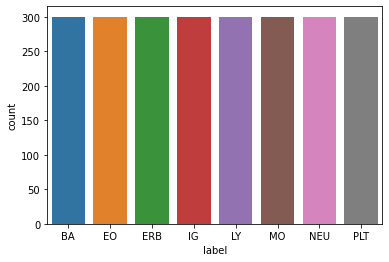

In [21]:
sample = df.groupby('label').sample(n=300)#.reset_index(drop = True)
sns.countplot(x=sample.label)

In [22]:
# Converting to dataframe
np_data = images_flat[sample.index]
df_data = pd.DataFrame(np_data)

In [23]:
# Encoding Label
target_sample = target[sample.index]

# PCA embedding

In [24]:
# Applying the PCA to our data
pca = PCA(n_components = 0.9)
X_pca = pca.fit_transform(df_data)

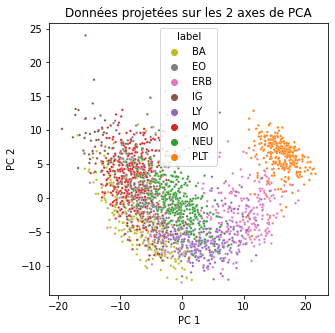

In [25]:
# Plotting our results
fig, ax = pyplot.subplots(figsize=(5,5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue = sample["label"], s=6, palette = 'tab10_r')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

ax.set_title("Données projetées sur les 2 axes de PCA")
plt.show()

It looks like our PCA model is able to distinguish between some categories. In fact, as we will see later on, it is very efficient in clustering the platelets (orange points).

In [26]:
# preparing the annotated images for the plot

sample['X'] = X_pca[:, 0]
sample['Y'] = X_pca[:, 1]
sample2 = sample.sample(frac=0.035)

#### Plotting the previous scatter plot with annotated images for our data

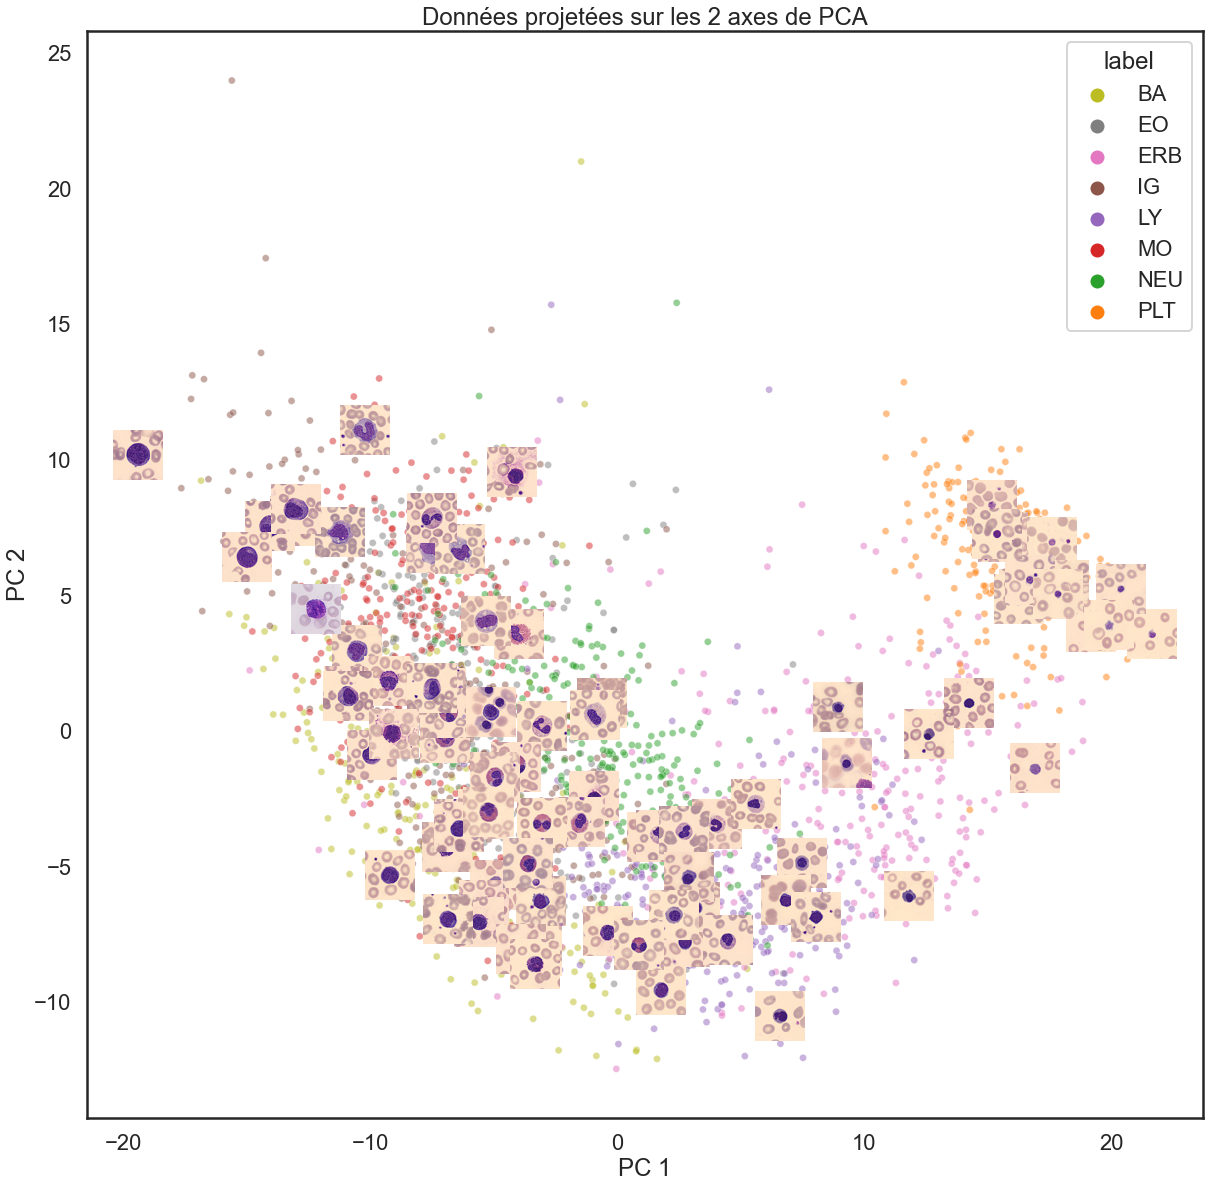

In [27]:
sns.set(context='poster', style='white')

def getImage(path):
    return OffsetImage(np.asarray(Image.open(path).resize((50,50))))

paths = sample2.img_paths
x1=np.array(sample2.X)
y1=np.array(sample2.Y)


x = X_pca[:, 0]
y = X_pca[:, 1]

fig, ax = plt.subplots(figsize=(20, 20))
sns.scatterplot(x=x, y=y, hue = sample.label, palette = 'tab10_r', s=50, alpha=0.5)


for x0, y0, path in zip(x1, y1,paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)
    
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

ax.set_title("Données projetées sur les 2 axes de PCA")
plt.show()

Just as we said previously, the PCA has been able to **distinguish between categories** according to the size of the bloodcells in the images, which makes it really useful for detecting platelet.

# LDA embedding

In [28]:
# Applying the LDA to our data
lda = LDA()
X_lda = lda.fit_transform(df_data,target_sample)

# Preparing for the results plotting
sample['X_lda'] = X_lda[:, 0]
sample['Y_lda'] = X_lda[:, 1]
sample2 = sample.sample(frac=0.05)

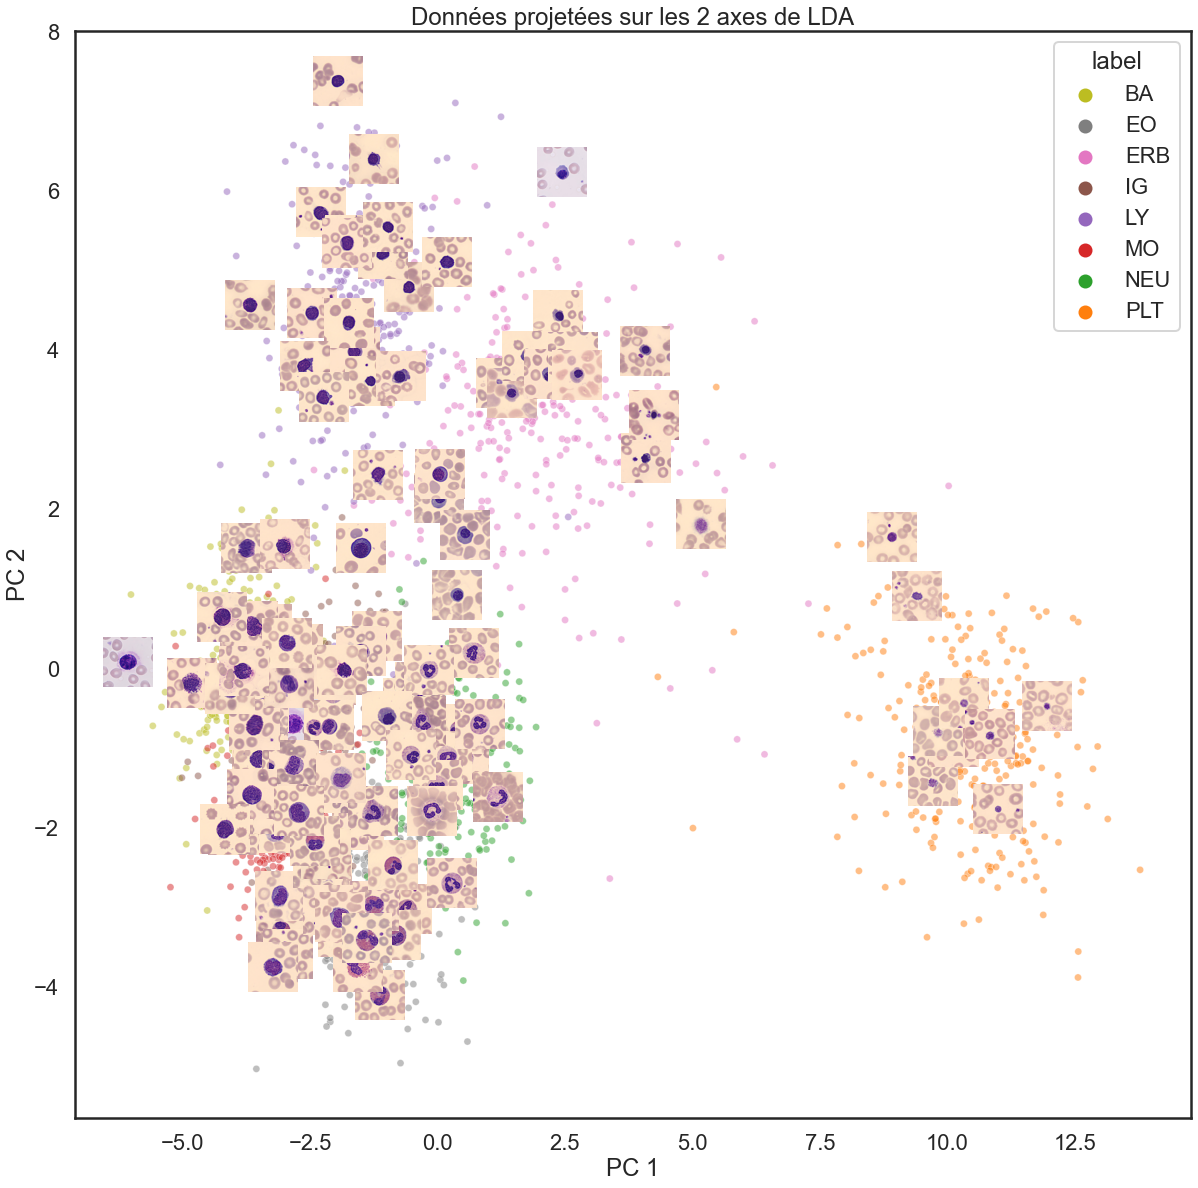

In [29]:
# Plotting the results
def getImage(path):
    return OffsetImage(np.asarray(Image.open(path).resize((50,50))))



paths = sample2.img_paths
x1=np.array(sample2.X_lda)
y1=np.array(sample2.Y_lda)


x = X_lda[:, 0]
y = X_lda[:, 1]

fig, ax = plt.subplots(figsize=(20, 20))
sns.scatterplot(x=x, y=y, hue = sample.label, palette = 'tab10_r', s=50, alpha=0.5)
for x0, y0, path in zip(x1, y1,paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

ax.set_title("Données projetées sur les 2 axes de LDA")
plt.show()

**Amazing !** Once again, we have been able to visually cluster some categories according to the bloodcell size.

# t-SNE embedding

In [30]:
# Applying t-SNE to our data
tsne = TSNE(n_components=2, perplexity = 40 ,method = 'barnes_hut')
dataTSNE = tsne.fit_transform(df_data)

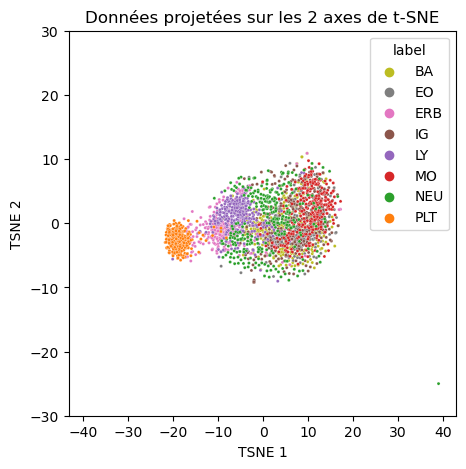

In [31]:
# Plotting the results
sns.reset_defaults()
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(111)
sns.scatterplot(x=dataTSNE[:, 0], y=dataTSNE[:, 1], hue = sample.label,  palette = 'tab10_r', s=5)

ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 2')
ax.set_title("Données projetées sur les 2 axes de t-SNE")
plt.ylim(-30, 30)
plt.show()

# UMAP emdedding 

While t-SNE is really good at conserving local distance, PCA is good at conversing global structure. The UMAP algorithm is good at maintaining both. Let's have a look.

### Applying our UMAP model


In [32]:
%%time
mapper = umap.UMAP(n_neighbors=5, random_state=42, n_jobs=6).fit(images_flat)
embedding = mapper.transform(images_flat)

CPU times: user 2min 13s, sys: 10.8 s, total: 2min 24s
Wall time: 59.8 s


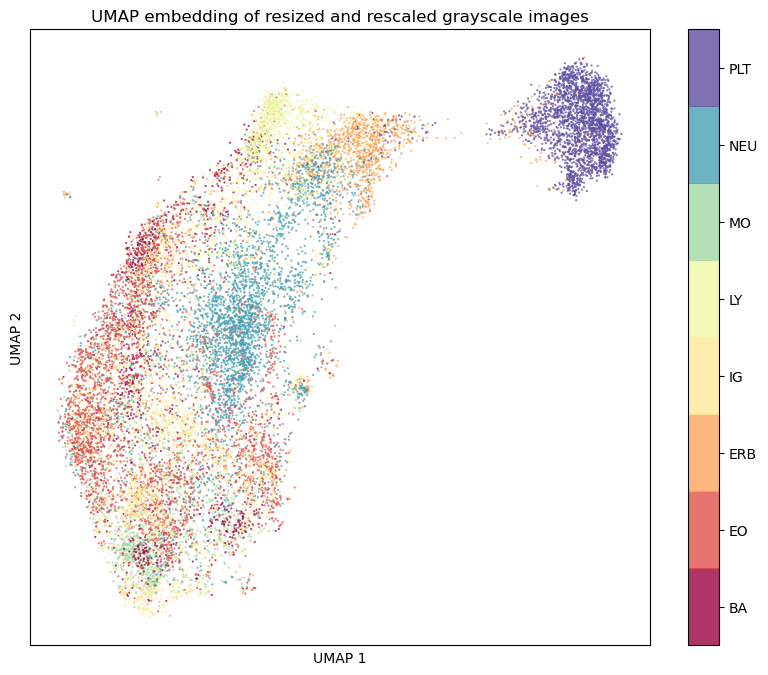

In [33]:
# Plotting the results
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding.T, s=0.3, c=target, cmap='Spectral', alpha=0.8)
plt.setp(ax, xticks=[], yticks=[])

cbar = plt.colorbar(boundaries=np.arange(len(le.classes_)+1)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(le.classes_)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.title('UMAP embedding of resized and rescaled grayscale images');

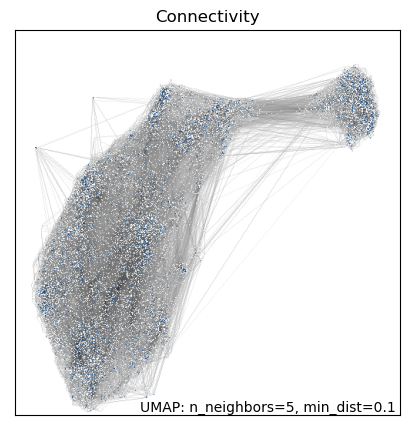

In [34]:
# Other visualisation
umap.plot.connectivity(mapper, show_points=True, width=500, height=500)
plt.title('Connectivity');

As with the other methods of dimension reduction, the platelets form a single cluster. We can also see that some of the cells appears to be in sub-cluster within the main cluster.  


We can check whethet the UMAP is performing good on the global distances using the PCA diagnosis tool.

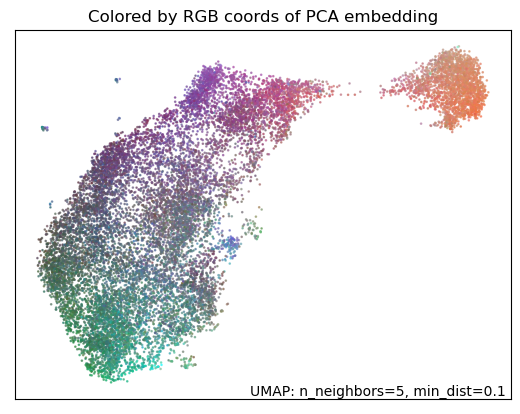

In [35]:
# Other visualisation
umap.plot.diagnostic(mapper, diagnostic_type='pca');

The plot that the UMAP was able to integrate **global variance** within its dimension reduction.

### UMAP on a subsample
Let's plot the image on a **subsample fitted with UMAP**

In [36]:
# Applying umap to our sample
%time

mapper_s = umap.UMAP(random_state=42, n_jobs=6).fit(np_data)
embedding_S = mapper.transform(np_data)

CPU times: user 2 µs, sys: 16 µs, total: 18 µs
Wall time: 22.2 µs


In [37]:
sample['X_UMAP'] = embedding_S[:, 0]
sample['Y_UMAP'] = embedding_S[:, 1]

sample2 = sample.sample(frac=0.035)
sample2
paths = sample2.img_paths
x_coord = sample2.X_UMAP.to_list()
y_coord = sample2.Y_UMAP.to_list()

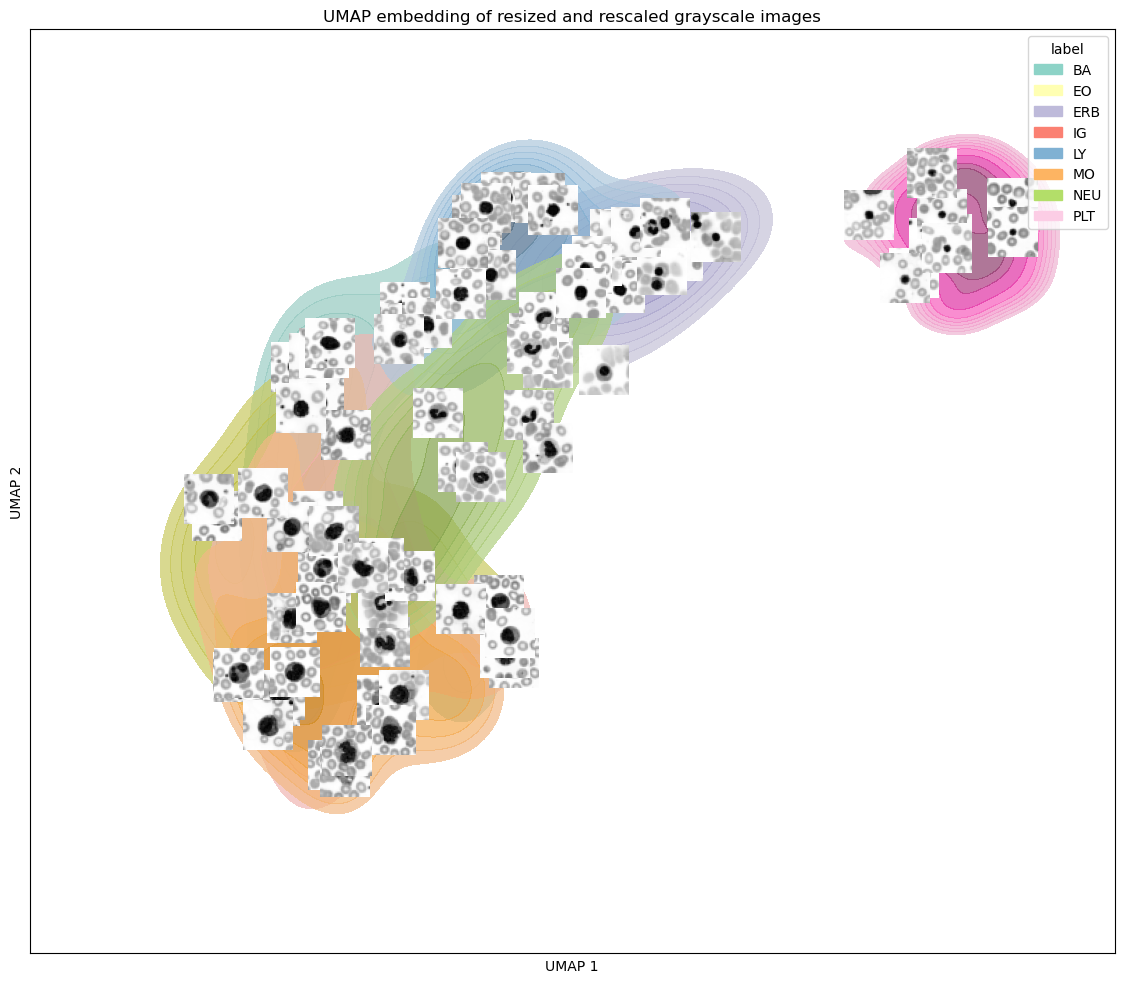

In [38]:
# Plotting the results
fig, ax = plt.subplots(1, figsize=(14, 12))
sns.kdeplot(x=sample.X_UMAP, y=sample.Y_UMAP, hue='label', data=sample, shade=True, thresh=0.2, alpha=0.7, palette='Set3')
plt.setp(ax, xticks=[], yticks=[])

plt.title('UMAP embedding of resized and rescaled grayscale images')


def getImage(path):
    return OffsetImage(leuko.load_image(path, as_grey=True, rescale=0.1),
                      cmap='gray')

for x, y, path in zip(x_coord, y_coord, paths):
    ab = AnnotationBbox(getImage(path), (x, y), frameon=False)
    ax.add_artist(ab)
    
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2');

We can clearly see here that the platelets stand out, moreover the UMAP is able to group other cells into subclusters and UMAP component 2 appears to differentiate cells by size and brightness.

/Users/yahiabouzoubaa/opt/anaconda3/lib/python3.8/site-packages/umap/plot.py:854: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


Text(0.5, 1.0, 'Connectivity showing hammer edges')

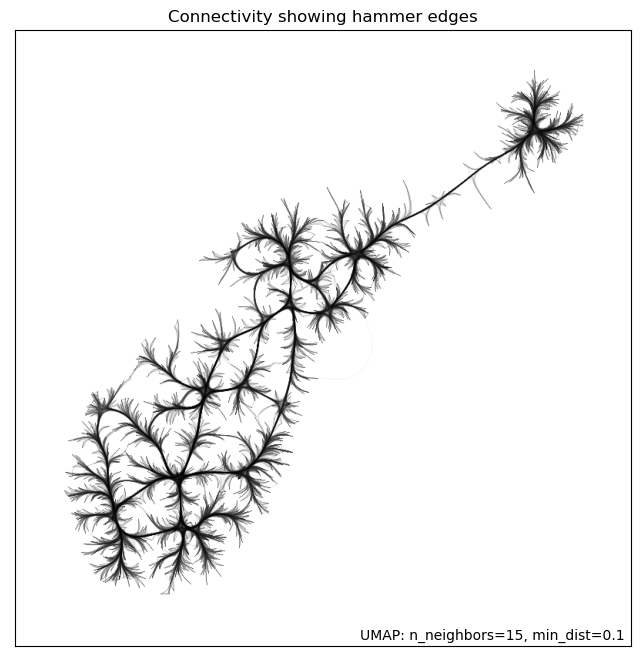

In [39]:
%%capture --no-stderr --no-stdout --no-display
umap.plot.connectivity(mapper_s, edge_bundling='hammer')
plt.title('Connectivity showing hammer edges')

### Supervised UMAP
We can also try to **supervised UMAP** with our labels

In [42]:
# Using supervised learning umap version
%time
embedding_lab = umap.UMAP().fit_transform(images_flat, y=target)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


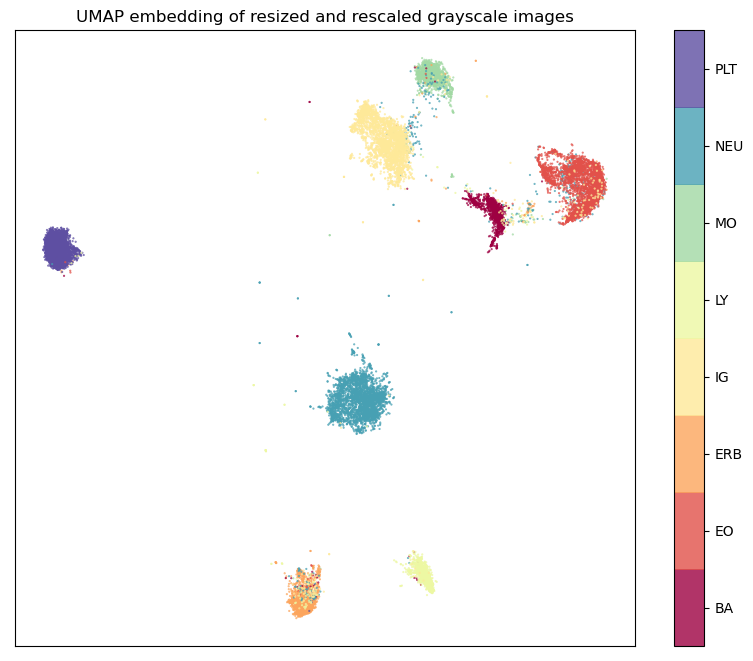

In [43]:
# Plotting results
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding_lab.T, s=0.3, c=target, cmap='Spectral', alpha=0.8)
plt.setp(ax, xticks=[], yticks=[])

cbar = plt.colorbar(boundaries=np.arange(len(le.classes_)+1)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(le.classes_)
plt.title('UMAP embedding of resized and rescaled grayscale images');

# Conclusion

Using dimension reduction, we found consistent separation of platelets from the rest of the cell. Platelets thus appears as an easy cell to classify. Those results are in agreements with the data from the luminance and deconvolution exploration.
The UMAP revealed that the cells tend to cluster together within an important cluster. On the PCA and UMAP, we could also observed that the size of cells and the brightness contribute to the global variance.

The supervised UMAP is an interesting model for dimension reduction as it manage to truly separate each cell groups. We will use it for our base model.

In [ ]:
1+1

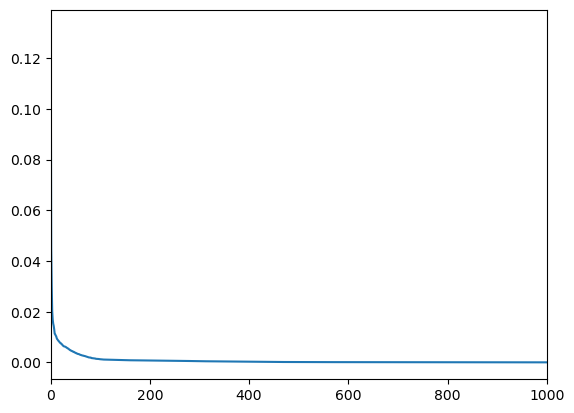

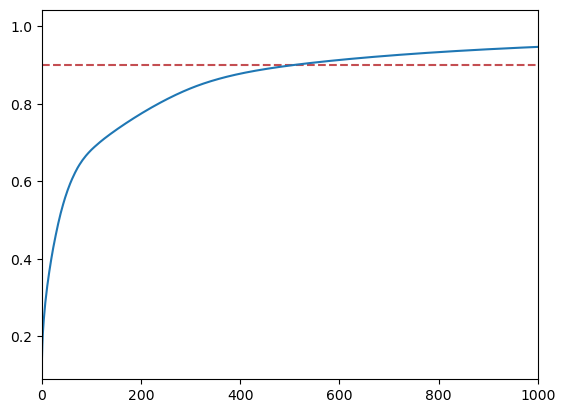

In [46]:
pca = PCA()
pca.fit(images_flat)

plt.figure()
plt.xlim(0,1000)
plt.plot(pca.explained_variance_ratio_);

plt.figure()
plt.xlim(0,1000)
plt.axhline(y = 0.9, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());

In [47]:
# C'est à partir d'environ 500 composants que nous obtenons une variance expliquée à hauteur de 90%
from sklearn.model_selection import train_test_split
pca = PCA(n_components = 0.9)
X_pca = pca.fit_transform(images_flat)


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, target,
                                                                    train_size = 0.8,
                                                                    random_state = 42)

In [51]:
parameters = {
    "n_estimators": [5, 10, 15, 20, 25], 
    "max_depth": [3, 5, 7, 9, 11, 13],
}

model_random_forest = RandomForestClassifier(
    class_weight='balanced',
)

model_random_forest = GridSearchCV(
    model_random_forest, 
    parameters, 
    cv=3,
    scoring='accuracy',
)

model_random_forest.fit(X_train_pca, y_train_pca)

print('-----')
print(f'Best parameters {model_random_forest.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_random_forest.best_score_:.3f}'
)

-----
Best parameters {'max_depth': 11, 'n_estimators': 25}
Mean cross-validated accuracy score of the best_estimator: 0.527


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

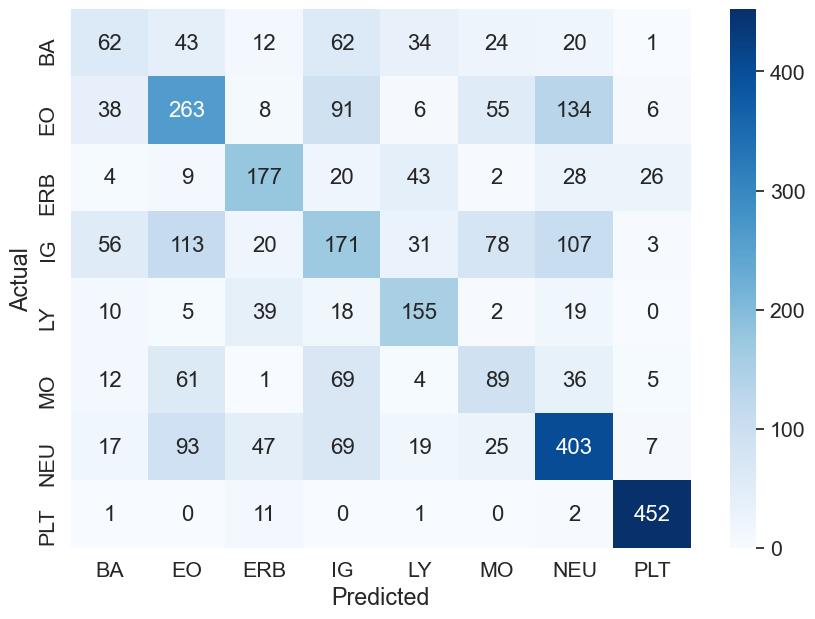

In [58]:
from sklearn.metrics import confusion_matrix
y_pred_pca = model_random_forest.predict(X_test_pca)
data = confusion_matrix(y_test_pca, y_pred_pca)
df_cm = pd.DataFrame(data, columns=le.classes_, index = le.classes_)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')

In [60]:
parameters = {
    "C": [0.001, 0.01, 0.1, 1.],
    "penalty": ["l1", "l2"]
}

model_logistic_regression = LogisticRegression(
    class_weight="balanced",
    solver="liblinear",
)

model_logistic_regression = GridSearchCV(
    model_logistic_regression, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_logistic_regression.fit(X_train_pca, y_train_pca)

print('-----')
print(f'Best parameters {model_logistic_regression.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_logistic_regression.best_score_:.3f}'
)

-----
Best parameters {'C': 0.1, 'penalty': 'l1'}
Mean cross-validated accuracy score of the best_estimator: 0.647


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

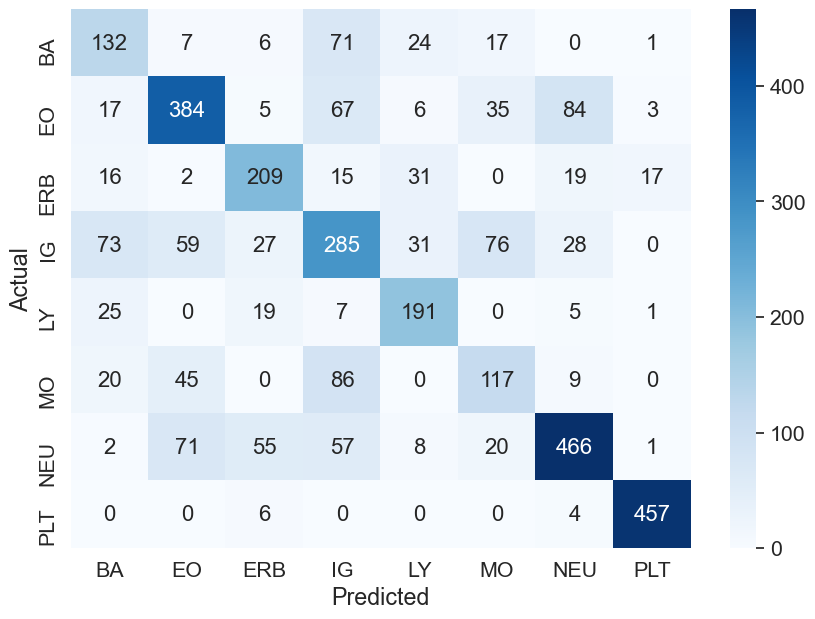

In [62]:
y_pred_pca = model_logistic_regression.predict(X_test_pca)
data = confusion_matrix(y_test_pca, y_pred_pca)
df_cm = pd.DataFrame(data, columns=le.classes_, index = le.classes_)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')

In [ ]:
# Using supervised learning umap version
%time
embedding_lab = umap.UMAP().fit_transform(images_flat, y=target)

In [63]:
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(embedding_lab, target,
                                                   train_size = 0.8,
                                                   random_state = 42)

In [64]:
parameters = {
    "n_estimators": [5, 10, 15, 20, 25], 
    "max_depth": [3, 5, 7, 9, 11, 13],
}

model_random_forest = RandomForestClassifier(
    class_weight='balanced',
)

model_random_forest = GridSearchCV(
    model_random_forest, 
    parameters, 
    cv=3,
    scoring='accuracy',
)

model_random_forest.fit(X_train_umap, y_train_umap)

print('-----')
print(f'Best parameters {model_random_forest.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_random_forest.best_score_:.3f}'
)

-----
Best parameters {'max_depth': 11, 'n_estimators': 20}
Mean cross-validated accuracy score of the best_estimator: 0.954


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

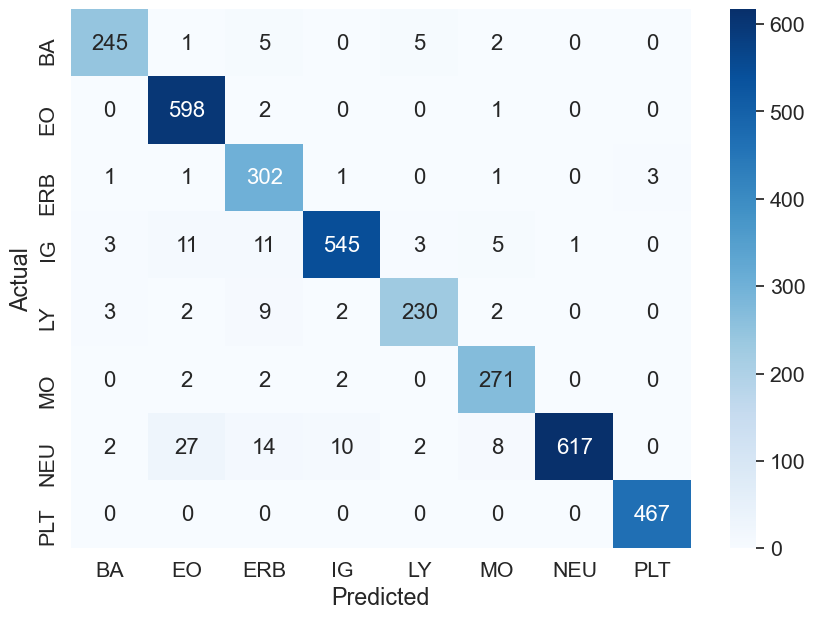

In [67]:
from sklearn.metrics import confusion_matrix
y_pred_umap = model_random_forest.predict(X_test_umap)
data = confusion_matrix(y_test_umap, y_pred_umap)
df_cm = pd.DataFrame(data, columns=le.classes_, index = le.classes_)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')

In [68]:
parameters = {
    "C": [0.001, 0.01, 0.1, 1.],
    "penalty": ["l1", "l2"]
}

model_logistic_regression = LogisticRegression(
    class_weight="balanced",
    solver="liblinear",
)

model_logistic_regression = GridSearchCV(
    model_logistic_regression, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_logistic_regression.fit(X_train_umap, y_train_umap)

print('-----')
print(f'Best parameters {model_logistic_regression.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_logistic_regression.best_score_:.3f}'
)

/Users/yahiabouzoubaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/yahiabouzoubaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/yahiabouzoubaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/yahiabouzoubaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/yahiabouzoubaa/opt/anaconda3/lib/python3.8/site-packages/skle

-----
Best parameters {'C': 0.1, 'penalty': 'l1'}
Mean cross-validated accuracy score of the best_estimator: 0.948


/Users/yahiabouzoubaa/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

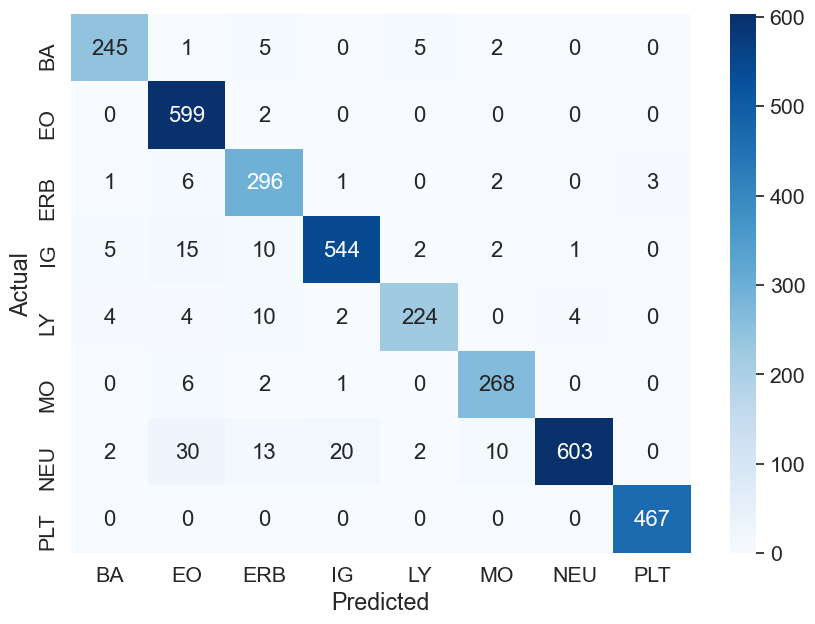

In [69]:
y_pred_umap = model_logistic_regression.predict(X_test_umap)
data = confusion_matrix(y_test_umap, y_pred_umap)
df_cm = pd.DataFrame(data, columns=le.classes_, index = le.classes_)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')